<a href="https://colab.research.google.com/github/DmytroBuzanov/Anomaly-Detection/blob/main/task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# Імпорт необхідних бібліотек

import pandas as pd
import pandas_profiling

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

from google.colab import drive
drive.mount('/content/drive')

!pip install pandas_profiling
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Зчитування даних

df = pd.read_csv('/content/drive/My Drive/data/2_news.csv')
df

,id,id_source,date,time,native_id,id_primary_ticker,move_date,reaction_date
0,160851877,5658,2020-01-03,06:33:00,202001030633FLYWALL_USEQUITY_55,12974,2020-01-03,2020-01-03
1,160854176,5650,2020-01-06,18:26:00,202001061826BENZINGANEWS____15081234,12974,2020-01-07,2020-01-07
2,160854196,5658,2020-01-06,18:31:00,202001061831FLYWALL_USEQUITY_783,12974,2020-01-07,2020-01-07
3,160855109,5649,2020-01-06,17:53:00,202001061753SEC_____EDGAR____A82HB22CZ222U2522...,12974,2020-01-07,2020-01-07
4,160855111,5649,2020-01-06,17:53:00,202001061753SEC_____EDGAR____AP2RD22CZ22242522...,12974,2020-01-07,2020-01-07
...,...,...,...,...,...,...,...,...
339081,163184755,5650,2020-12-09,04:55:00,202012090455BENZINGANEWS____18708323,17986,2020-12-09,2020-12-09
339082,163206877,5624,2020-12-14,06:13:00,3180159,17986,2020-12-14,2020-12-14
339083,163208225,5649,2020-12-15,17:18:00,202012151718SEC_____EDGAR____ARZQD22CZC22B92E2...,17986,2020-12-16,2020-12-16
339084,163217310,5650,2020-12-16,12:43:00,202012161243BENZINGANEWS____18820743,17986,2020-12-16,2020-12-16


**Аналіз даних (пошук тенденцій та аномалій)**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339086 entries, 0 to 339085
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 339086 non-null  int64 
 1   id_source          339086 non-null  int64 
 2   date               339086 non-null  object
 3   time               339086 non-null  object
 4   native_id          339086 non-null  object
 5   id_primary_ticker  339086 non-null  int64 
 6   move_date          339086 non-null  object
 7   reaction_date      339086 non-null  object
dtypes: int64(3), object(5)
memory usage: 20.7+ MB


In [7]:
df.describe()

,id,id_source,id_primary_ticker
count,3.390860e+05,339086.000000,339086.000000
mean,1.618574e+08,5648.867818,18095.295176
std,6.665854e+05,11.336878,18488.513976
min,1.608372e+08,5624.000000,7571.000000
25%,1.612987e+08,5649.000000,9541.000000
50%,1.617787e+08,5650.000000,12120.000000
75%,1.623195e+08,5658.000000,14697.000000
max,1.632821e+08,5666.000000,75594.000000


In [11]:
pd.read_csv(r'/content/drive/My Drive/data/2_news.csv').profile_report()

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
df.groupby(['date'], as_index=False) \
  .aggregate({'id_primary_ticker': 'count'}).sort_values(by=['id_primary_ticker'])

,date,id_primary_ticker
359,2020-12-25,3
24,2020-01-25,6
248,2020-09-05,7
276,2020-10-03,10
185,2020-07-04,10
...,...,...
302,2020-10-29,2562
35,2020-02-05,2597
42,2020-02-12,2722
34,2020-02-04,2738


In [9]:
df.groupby(['id_primary_ticker', 'date'], as_index=False) \
  .aggregate({'move_date': 'count',
              'reaction_date': 'count'}) \
  .sort_values(by=['move_date'])

,id_primary_ticker,date,move_date,reaction_date
0,7571,2020-01-02,1,1
49102,12803,2020-06-08,1,1
49103,12803,2020-06-10,1,1
49104,12803,2020-06-12,1,1
49107,12803,2020-06-18,1,1
...,...,...,...,...
35639,11465,2020-03-02,116,116
43272,12168,2020-03-03,118,118
29544,10594,2020-12-28,127,127
592,7585,2020-01-29,138,138


In [10]:
df.groupby(['id_source'], as_index=False) \
  .aggregate({'id_primary_ticker': 'count'})

,id_source,id_primary_ticker
0,5624,50616
1,5649,98359
2,5650,68206
3,5656,28666
4,5658,79169
5,5666,14070


In [17]:
# Пошук аномалій

df = df[['id','id_source',	'date',	'time',	
         'id_primary_ticker', 'move_date', 'reaction_date']]
df['move_date'] = pd.to_numeric(pd.to_datetime(df['move_date']))
df['reaction_date'] = pd.to_numeric(pd.to_datetime(df['reaction_date']))   
df['date'] = pd.to_numeric(pd.to_datetime(df['date']))
df['time'] = pd.to_numeric(pd.to_datetime(df['time']))

outliers_fraction = float(.01)
scaler = StandardScaler()
np_scaled = scaler.fit_transform(df.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)

# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.01,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [18]:
data.drop_duplicates()

,0
0,-1.154570
1,-1.154570
2,0.837874
3,0.895285
4,-1.154570
...,...
2131381,-1.154570
2144919,-1.154570
2167837,-1.154570
2184273,-1.154570


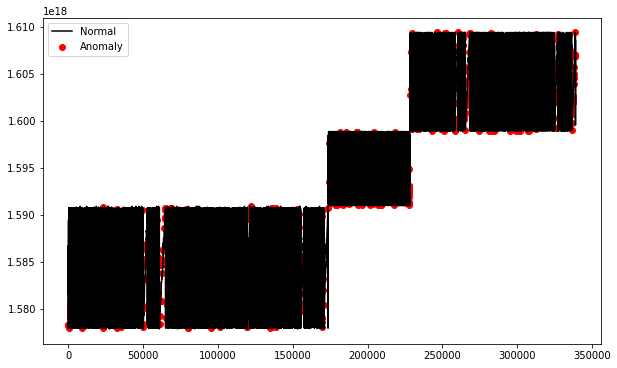

In [19]:
df['anomaly'] = model.predict(data.head(339086))
# visualization
fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly'] == -1, ['date']] #anomaly
ax.plot(df.index, df['date'], color='black', label = 'Normal')
ax.scatter(a.index, a['date'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

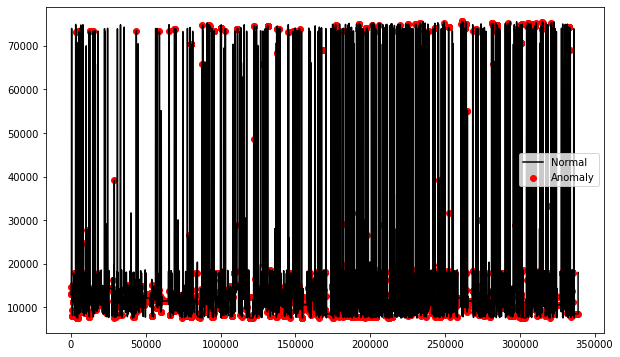

In [20]:
df['anomaly'] = model.predict(data.head(339086))
# visualization
fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly'] == -1, ['id_primary_ticker']] #anomaly
ax.plot(df.index, df['id_primary_ticker'], color='black', label = 'Normal')
ax.scatter(a.index, a['id_primary_ticker'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

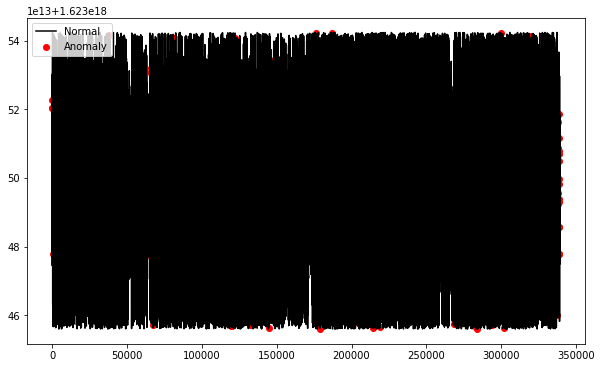

In [21]:
df['anomaly'] = model.predict(data.head(339086))
# visualization
fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly'] == -1, ['time']] #anomaly
ax.plot(df.index, df['time'], color='black', label = 'Normal')
ax.scatter(a.index, a['time'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

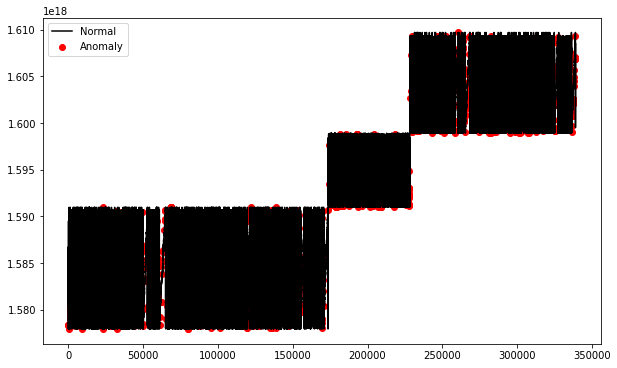

In [22]:
df['anomaly'] = model.predict(data.head(339086))
# visualization
fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly'] == -1, ['move_date']] #anomaly
ax.plot(df.index, df['move_date'], color='black', label = 'Normal')
ax.scatter(a.index, a['move_date'], color='red', label = 'Anomaly')
plt.legend()
plt.show();